### New Version of Experiments and Feature+Parameter Selection

Ver2.0 Make-up experiments based on the complete version torn_pred.ipynb 

1. Comparison Experiments - 

When calculating shsr features, we use the SHRS frame 30min before weather phenomena (tornado/wind/hail) happened. Data saved as balanced_comb_bf30min.csv file.

Short Conclusion - Extracting features from SHSR frame 30min before weather phenomenon happens will - 1)result in worse overall performance, 2) do harm to different categories' performances, not only tornado (however, under certain situation, tornado's prediction performance is not negatively influenced). 

2. Feature and Hyper-parameter Selection - (presented in torn_pred_feat_sel.ipynb) 

Use Boruta, RFE, RFA to run experiment, such that we can obtain better performances because of better feature combinations and best threshold.


# Tornado Prediction 

In this project, we are doing 3-category ("torn":0, "wind":1, "hail":2) classification based on some tabular data. We will use interpretable Logistic Regression as the baseline method and compare its performance with 3 advanced models on MRMS Dataset:
1. Random Forest;
2. LightGBM;
3. XGBoost;

MRMS Dataset contains weather data at different time and location. The data contains 1.varaibles related to weather (e.g. temperture, humidity, etc), 2.SHSR data. 3. label - weather type (tornado, wind, hail, etc).

Note - In this whole project, we will consistently use widely-used python libraries, like numpy, pandas and sklearn. 

In [9]:
# Load necessary libraries. 
import os 
import tqdm
import random 
import numpy as np 
import pandas as pd 
import sklearn.metrics as metrics
import shap 

# import our models 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor 
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier 

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## 1. Split Data and Data Preprocessing

For now, we can only use .nc files' SHSR data to do classification or only use tabular data collected by us. [Their timestamp and location are not matching]. 

csvdata_combine_and_split(csv_path, cls_names, vars, ratio=[4,1,1], comb_file="comb") 

funcs 
1. Randomly split the data into train/val/test sets with the ratio 4:1:1;
2. Only keep given variables for later training and prediction;
3. In original data, 'preciptype' is nan or ['rain'], replace them with 0 and 1;
4. [for now] Replace all missing values with 0;
5. Save the combined file as "Combine_with_Temp/comb.csv".

Select proper varaibles that will be used for later training and prediction by defining a list vars;
We are building diagnostic model at one location and time stamp (ignore columns describing time and location);
In original csv file - all variables: <class 'numpy.float64'> dtype;  'preciptype': <class 'float'> / <class 'str'> dtype;

[torn] category, 1359 items; [wind] category, 15525 items; [hail] category, 6261 items;

In [1]:
import numpy as np 
import pandas as pd 
import xarray as xr 
from netCDF4 import Dataset
from operator import itemgetter

threshold = 45          # can change threshold at certain window ... 
nc_path = "data/SHSRdata/"
csv_path = "data/"
cls_names = { "torn":0, "wind":1, "hail":2 }

def time_diff( t1, t2, shift=6 ):  
    # the shift here means 
    (h1,m1), (h2,m2) = t1, t2 
    h2 = (h2+shift)%24 
    return abs( (h1-h2)*60 + m1-m2 ) 

# Create new features based on SHSR data (Note - there might be some missing values).
# Important - Select the SHSR timeframe that is closest to weather type's happening time. 
def get_shsr_stats( nc_path, n, label, if_window = False ):
    stats = { "mean":[], "max":[], "min":[], "var":[], "nonzeros":[], "above_threshold":[] }
    for i in tqdm.tqdm( range(n) ):
        if os.path.exists( nc_path + "/{}.nc".format(i) ):
            xr_data = xr.open_dataset(nc_path + "/{}.nc".format(i) ) 
            csv_data = pd.read_csv( csv_path+"2021_{}.csv".format(label) ).iloc[i]
            
            # select closest timeframe ... 
            tmp = str( csv_data["time"] )
            # print(tmp)
            if tmp[1]==":":
                h, x = 0, 2
            elif tmp[0] == "0":
                h, x = int(tmp[1]), 3
            else:
                h, x = int(tmp[:2]), 3
            m = int(tmp[x:x+2]) 
            shsr = xr_data["SHSR"].values
            tmps = []
            for i in range( len(xr_data['time']) ):
                tmp = str(xr_data['time'][i].values)
                if tmp[11] == "0":
                    h_ = int(tmp[12])
                else:
                    h_ = int(tmp[11])
                m_ = int(tmp[14:16])
                tmps.append( time_diff( [h_,m_], [h,m] ) ) 
            index, element = min(enumerate(tmps), key=itemgetter(1))
            index = max(index-3,0) 
            shsr_frame = shsr[index] 
            m,n = shsr_frame.shape 
            x,y = int(m/2), int(n/2) 
            # we need to crop the intensity map as (20,20) shape at center
            crop_frame = shsr_frame[x-15:x+15,y-15:y+15]
            tmp = [ np.mean(shsr_frame), np.max(shsr_frame), np.min(shsr_frame), np.var(shsr_frame), 
                   np.count_nonzero(shsr_frame), len( crop_frame[crop_frame>threshold] ) ]   # take care ... 
        else:
            tmp = [0,0,0,0,0,0] 
        stats["mean"].append( tmp[0] )
        stats["max"].append( tmp[1] )
        stats["min"].append( tmp[2] )
        stats["var"].append( tmp[3] )
        stats["nonzeros"].append( tmp[4] ) 
        stats["above_threshold"].append( tmp[4] ) 
    return stats 

for cls in cls_names:
    frame_extra = pd.read_csv( csv_path+"2021_{}_UTC_combine_temperature.csv".format(cls) ) 
    frame_index = pd.read_csv( csv_path+"2021_{}.csv".format(cls) ) 
    print( f"The lengths of {cls}'s extra variables and indexes are {len(frame_extra)} and {len(frame_index)}" )

The lengths of torn's extra variables and indexes are 1364 and 1364
The lengths of wind's extra variables and indexes are 15525 and 15525
The lengths of hail's extra variables and indexes are 6261 and 6261


In [2]:
import time 

nc_path = "data/SHSRdata/"
csv_path = "data/" 
cls_names = { "torn":0, "wind":1, "hail":2 }  # weather type and their assigned labels 
vars = [ 'temp', 'humidity', 'dew', 'precip', 'preciptype', 'windspeed', 'winddir', 'pressure', 'cloudcover', 'visibility']
stat_vars = [ "mean", "max", "min", "var", "nonzeros", "above_threshold" ]

def csvdata_combine_and_split(csv_path, cls_names, vars, ratio=[4,1,1], save_file="comb"): 
    # the way to split pandas data 
    comb = []
    for cls in cls_names:
        frame = pd.read_csv( csv_path+"2021_{}_UTC_combine_temperature.csv".format(cls) )
        frame = frame.fillna(0)
        curr = frame[ vars ]
        n = len(curr)
        preciptypes = [ 0 ] * n
        for i in range(n):
            if curr['preciptype'][i] == "['rain']":
                preciptypes[i] = 1
            else:
                preciptypes[i] = 0
        curr['preciptype'] = preciptypes
        print( f"In [{cls}] category, there are { n } items in total" )
        stats = get_shsr_stats( nc_path+"/"+cls+"/", n, cls, False )
        for stat in stats:
            curr[stat] = stats[stat] 
        sets = [ "val" ]*int(n/sum(ratio)) + ["test"]*int(n/sum(ratio)) + ["train"]*(n-2*int(n/ sum(ratio) )) 
        random.shuffle(sets) 
        cls_list = [ cls_names[cls] ] * n 
        curr['label'] = cls_list    
        curr['set'] = sets 
        curr = curr.sample(n=1364) 
        comb.append(curr) 
    comb = pd.concat( comb, axis=0 ) 
    comb.to_csv( csv_path + save_file + ".csv" ) 

# uncomment to create split data randomly and save as a new comb.csv
# time1 = time.time()
# csvdata_combine_and_split(csv_path, cls_names, vars, ratio=[4,1,1], save_file="balanced_comb_bf30min")
# time2 = time.time()
# print( "It takes {}s to finish creating train/val/test sets.".format(time2 - time1) ) 
vars += stat_vars

#### Functions to Read Dataset for Training/Validation/Test. 
provide functions to read our combined data as train/val/test sets, data/labels.

In [3]:
# we should balance train data among different categories ... 
def read_data( csv, vars, set='train' ):
    dframe = pd.read_csv( csv )
    x = dframe[ dframe['set']==set ][vars]
    y = dframe[ dframe['set']==set ]['label'].values        
    return x,y 

In [5]:
# Choose the Data we will use for training and test.
csv_file = "balanced_comb_bf30min.csv"
train_x, train_y = read_data( csv_path + "/" + csv_file, vars, set="train" )
print( f"The number of data points in train set:\n", train_x.shape, train_y.shape )
print( type(train_x), type(train_y) ) 
val_x, val_y = read_data( csv_path + "/" + csv_file, vars, set="val" )
print( f"The number of data points in val set:\n", val_x.shape, val_y.shape )
test_x, test_y = read_data( csv_path + "/" + csv_file, vars, set="test" )
print( f"The number of data points in test set:\n", test_x.shape, test_y.shape )

# train_x, train_y, val_x, val_y, test_x, test_y = read_data( csv_path + "/" + csv_file, vars, random_balanced = True )  
# print( f"The number of data points in train set:\n", train_x.shape, train_y.shape )

The number of data points in train set:
 (2744, 16) (2744,)
<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
The number of data points in val set:
 (673, 16) (673,)
The number of data points in test set:
 (675, 16) (675,)


## 2. Building Machine Learning Models for 3-Category Prediction 

Models
1. [Baseline] Logistic Regression;
2. Random Forest;
3. LightGBM;
4. XGBoost;

Evaluation:
1. Accuracy, Precision, Recall, F1 Score; 
2. Confusion Matrix;


In [6]:
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay 

def evaluate( model, train_x, train_y, test_x, test_y ):
    """ uses the model to calculate a set of scores """
    # accuracy_score
    print('Test Accuracy     :',model.score(test_x, test_y))
    print('Training Accuracy    :',model.score(train_x,train_y))
    # print( test_x[:10], "\n", test_y[:10] )
    pred_y = model.predict(test_x)
    # acc = accuracy_score( test_y, pred_y )
    # print(acc)
    precision = precision_score( test_y, pred_y, average='weighted', zero_division=True )
    recall = recall_score( test_y, pred_y, average='weighted' )
    f1 = f1_score( test_y, pred_y, average='weighted')
    print('Testing precision :', precision )
    print('Testing recall    :', recall )
    print('F1 score          :', f1 )
    # ROC AUC
    probs=model.predict_proba(test_x) 
    print('ROC AUC           : %f' % roc_auc_score(test_y, probs, average="weighted", multi_class='ovo'))
    conf_mat = confusion_matrix( test_y, pred_y, normalize='true' )
    disp = ConfusionMatrixDisplay(conf_mat, display_labels=["torn", "wind", "hail"])
    disp = disp.plot(cmap=plt.cm.Blues)   # ,values_format='g'
    plt.show()

#### 1. Logistic Regression 

Logistic Regression is ...

======================= Logistic Regression =======================
Test Accuracy     : 0.5911111111111111
Training Accuracy    : 0.6009475218658892
Testing precision : 0.5903324220653994
Testing recall    : 0.5911111111111111
F1 score          : 0.5896061542336335
ROC AUC           : 0.771222


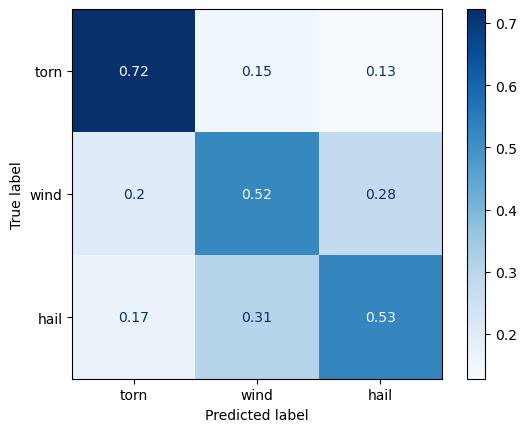

In [10]:
print('======================= Logistic Regression =======================')
lg = LogisticRegression(C=0.01,penalty='l2',max_iter=30000, 
                           solver="lbfgs",multi_class='multinomial', 
                           random_state=0)

lg.fit(train_x.values,train_y) 
evaluate(lg, train_x.values, train_y, test_x.values, test_y) 

#### 2. Random Forest 

Random Forest is ...

======================= Random Forest =======================
Test Accuracy     : 0.6459259259259259
Training Accuracy    : 0.6690962099125365
Testing precision : 0.6448774645929185
Testing recall    : 0.6459259259259259
F1 score          : 0.6446640312165947
ROC AUC           : 0.804441


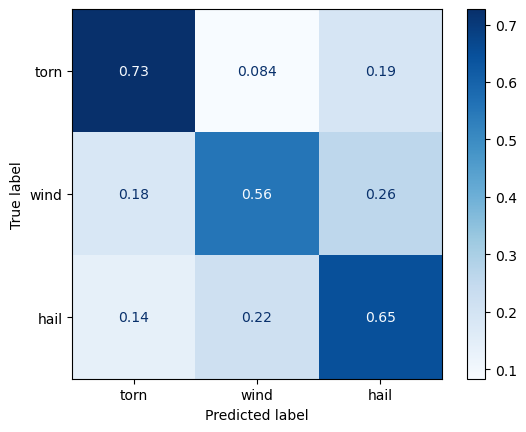

In [11]:
print('======================= Random Forest =======================')
# params = {
#     "criterion":'gini', "max_depth":20, "min_samples_split":30, "min_samples_leaf":3, "min_weight_fraction_leaf":0.5, "max_features":'sqrt', 
#     "max_leaf_nodes":5, "min_impurity_decrease":0.0, "bootstrap":True, "oob_score":False, "n_jobs":4, "random_state":None, 
#     "verbose":0, "warm_start":True, "class_weight":None, "ccp_alpha":0.0, "max_samples":None
# }

rfc = RandomForestClassifier( n_estimators= 100, max_depth=15, min_samples_split=110,
                                 min_samples_leaf=25,max_features='sqrt' ,oob_score=True,random_state=10 )
rfc.fit(train_x.values, train_y)
evaluate(rfc, train_x.values, train_y, test_x.values, test_y) 

#### 3. LightGBM
LightGBM is ...

============================= LightGBM =============================
Test Accuracy     : 0.6696296296296296
Training Accuracy    : 1.0
Testing precision : 0.6710327448411483
Testing recall    : 0.6696296296296296
F1 score          : 0.6699424746793168
ROC AUC           : 0.819672


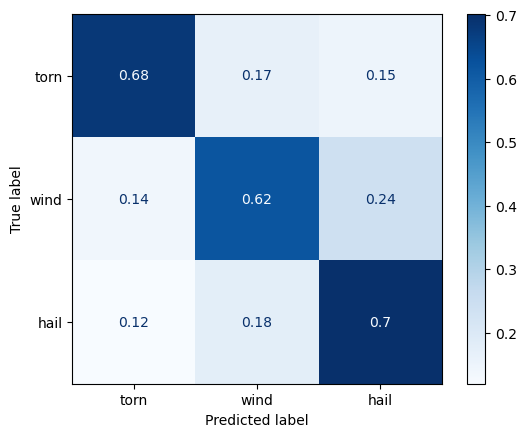

In [12]:
print('============================= LightGBM =============================')
params = {
            'objective':"multiclass",
            'metric' : 'multi_logloss',
            'num_class': 3,
            'verbose' : -1,    # what does verbose mean???
            'boosting_type' : 'gbdt',
            'colsample_bytree' : 0.2,
            'num_leaves' : 10,
            'max_depth' : 3,
            'n_estimators' : 5000,
            'min_child_samples': 10, 
            'min_child_weight': 0.5,
            'reg_alpha': 0.1,
            'reg_lambda': 10,
            'subsample': 0.6,
            'num_threads' : 4,
            'learning_rate':0.02
}

lgb = LGBMClassifier( n_estimators=5000, verbose=-1 )
lgb.fit(train_x, train_y)
evaluate( lgb, train_x, train_y, test_x, test_y )

#### 4. XGBoost 
XGBoost is ... 

============================= XGBoost =============================
Test Accuracy     : 0.6503703703703704
Training Accuracy    : 0.9981778425655977
Testing precision : 0.6517257401308848
Testing recall    : 0.6503703703703704
F1 score          : 0.650595383520664
ROC AUC           : 0.821395


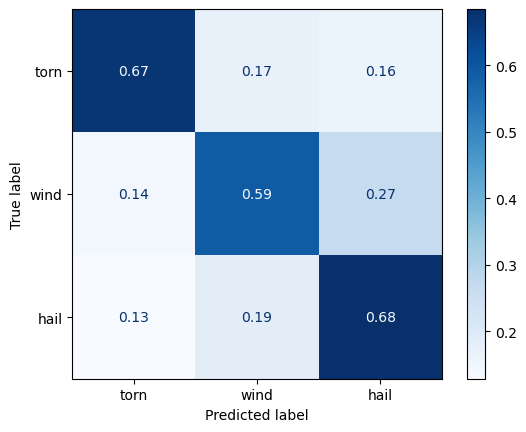

In [13]:
print('============================= XGBoost =============================')

param = {'base_score':0.34,'booster':'gbtree','objective':'multi:softmax',
        'max_delta_step':2,'n_jobs':4,'random_state':0, 'max_depth':3,
         'min_child_weight':3,'n_estimators':5000,'subsample':1.0,'colsample_bytree':0.3,
         'reg_lambda':10,'reg_alpha':0.1,'learning_rate':0.02,'gamma':0.3}    

xgb = XGBClassifier()
xgb.fit(train_x, train_y) 
evaluate( xgb, train_x, train_y, test_x, test_y )

## 3. Shap - Black-Box Machine Learning Model Output Analysis 

Here, we use shap library to help us identify the importance of each feature to the model outputs. 

#### Shap Feature Importance for LightGBM Model

============================== SHAP ===============================


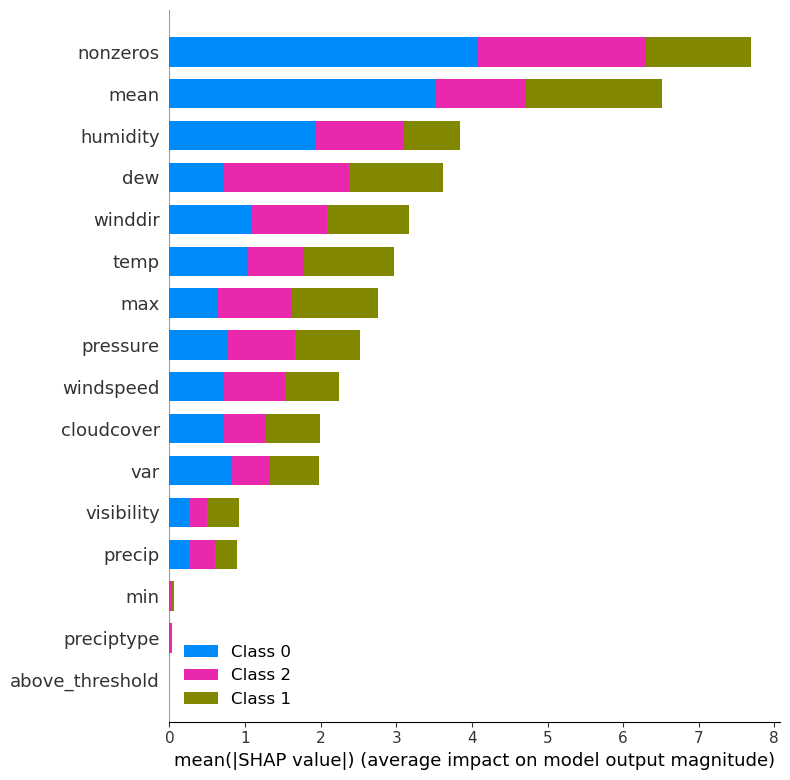

In [14]:
# to analysis different model, please replace the model that will be analyzed by Shap library.
# models that can be explained - rfc, lgb, xgb 

print('============================== SHAP ===============================')
explainer = shap.TreeExplainer(lgb)   # define the explainer
test_shap = explainer.shap_values(test_x)
shap.summary_plot(test_shap, test_x, plot_type="bar")

#### Shap Feature Importance for XGBOOST Model

============================== SHAP ===============================


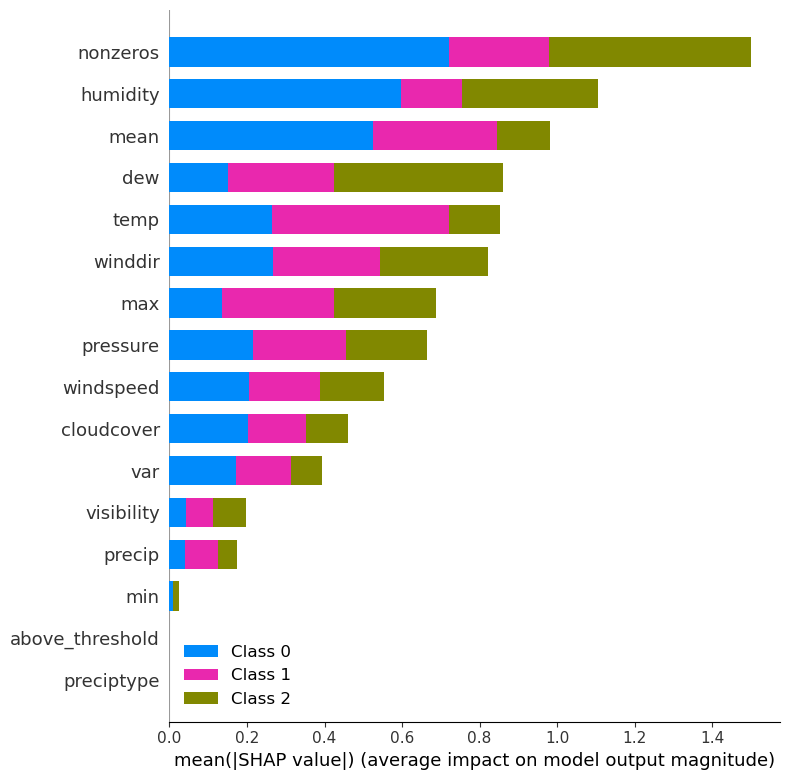

In [15]:
# to analysis different model, please replace the model that will be analyzed by Shap library.
# models that can be explained - rfc, lgb, xgb 

print('============================== SHAP ===============================')
explainer = shap.TreeExplainer(xgb)   # define the explainer
test_shap = explainer.shap_values(test_x)
shap.summary_plot(test_shap, test_x, plot_type="bar")